In [1]:
name = "normal1"

In [2]:
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from tensorflow.keras.models import Model

from tensorflow.keras.regularizers import l2


baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(240, 320, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten()(headModel)
headModel = Dense(674, activation="relu", kernel_regularizer=l2(0.0001))(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(512, activation="relu", kernel_regularizer=l2(0.0001))(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)


for layer in baseModel.layers:
    layer.trainable = False
    
model.load_weights('resnet50_wts_70-30.h5')

In [3]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 246, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 120, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 120, 160, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [4]:
last_conv_layer_name = "conv5_block3_out"
classifier_layer_names = [
    "average_pooling2d",
    "flatten",
    "dense",
    "dropout",
    "dense_1",
    "dropout_1",
    "dense_2"
]

In [5]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [6]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

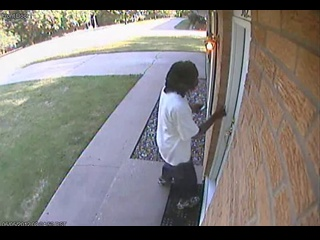

In [7]:
img_path = keras.utils.get_file(
    f"{name}.jpg", " https://i.imgur.com/Bvro0YD.png"
)

display(Image(img_path))

In [8]:
img_size = (240, 320)

In [9]:
preprocess_input = keras.applications.resnet50.preprocess_input
img_array = preprocess_input(get_img_array(img_path, size=img_size))

In [10]:
decode_predictions = keras.applications.resnet50.decode_predictions

In [11]:
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

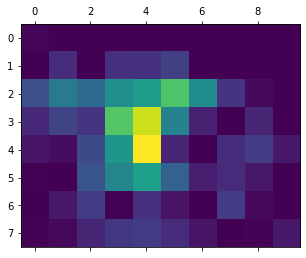

In [12]:
plt.matshow(heatmap)

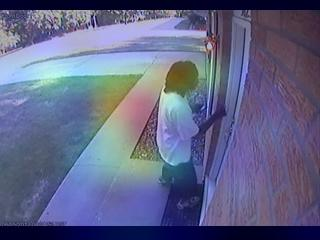

In [13]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = f"./gradcam/{name}.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))